# Packages

In [1]:
import time
import pandas as pd
import numpy as np
import os
import seaborn as sns
import cv2
import glob
import re
import string
import imageio
import imutils
import tqdm.notebook as tqdm
import multiprocessing
import matplotlib.pyplot as plt
from matplotlib.image import imread
import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict
from IPython.display import Image
from scipy.ndimage import gaussian_filter
from PIL import Image as Image_PIL
from PIL import ImageOps

%matplotlib inline

from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn import cluster, metrics, preprocessing, manifold, decomposition
from sklearn import manifold, decomposition
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import preprocessing
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications import resnet, ResNet50, vgg16, VGG19, vgg19, Xception, xception, InceptionV3, inception_v3

# Fonctions

#### Fonctions de manipulation sur les images

In [2]:
# Redimensionnement des images
def redim(picture, w, h):
    # picture : image à redimensionner
    # w, h : dimensions souhaitées
    
    min_x = 100000
    max_x = 0
    min_y = 100000
    max_y = 0
    im = np.array(Image_PIL.open(picture))
    shape = im.shape
    
    if shape[0] < min_x:
        min_x = shape[0]
    elif shape[0] > max_x:
        max_x = shape[0]
    if shape[1] < min_y:
        min_y = shape[1]
    elif shape[1] > max_y:
        max_y = shape[1]
        
    im_redim = cv2.resize(im, dsize=(w,h))
    del shape
    return im_redim

In [3]:
# Fonction de listing des images par catégories
def list_fct(name) :
    # name : nom à appliquer
    
    list_image_name = [df_img['img'][i] for i in range(len(df_img)) if df_img['main_cat'][i]==name]
    return list_image_name

In [4]:
# Fonction de génération des descripteurs SIFT
def features_sift(picture):
    
    img = cv2.imread(picture)
    img = cv2.resize(img, dim)

    img = cv2.GaussianBlur(img, (3, 3), cv2.BORDER_DEFAULT)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    keypoints = sift.detect(img, None)[:size]
    keypoints, descriptors = sift.compute(img, keypoints)

    if descriptors is not None:
        if len(descriptors) >= size:
            features = descriptors
        else:
            features = np.NaN
    else:
        features = np.NaN

    return features

#### Fonctions relative à la modélisation et l'évaluation

In [5]:
# Fonction de réduction de données via PCA, affichage des dimensions et calcul de l'ARI
def PCA_eval(X):
    # X : data à traiter
    
    # Réduction via PCA
    print("Dimension initiale : ", X.shape)
    num_labels=len(l_cat)
    X_std = X
    n_comp = int(round(min(X_std.shape[0], X_std.shape[1] * 0.5), 0))
    pca = decomposition.PCA(n_components=n_comp)
    time1 = time.time()
    pca.fit(X_std)
    c = 1
    while pca.explained_variance_ratio_[0:c].cumsum()[-1] < 0.95:
        c += 1

    pca = decomposition.PCA(n_components=c)
    X_reduced = pca.fit_transform(X_std)
    print("Dimension finale :", X_reduced.shape)
    
    # KMeans après réduction PCA, et ARI 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_reduced)
    time2 = np.round(time.time() - time1,0)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    print("ARI : ", ARI, "/ Time : ", time2)
    return ARI

In [6]:
# Réduction via T-SNE
# clusterisation via KMeans
# évaluation via ARI entre vraies catégories et clusters du KMeans
def ARI_fct(features) :
    
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    time1 = time.time()
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters KMeans après réduction T-SNE 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    time2 = np.round(time.time() - time1,0)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    print("ARI : ", ARI, "/ Time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# Visualisation du T-SNE selon les vraies catégories et les clusters KMeans
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des articles par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    title_plot = 'Représentation des descriptions par clusters ' + method
    plt.title(title_plot)
    
    plt.show()

In [7]:
# Fonction de génération des prédictions pour la matrice de confusion
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [8]:
# Fonction de génération de la matrice de confusion
def CM_matrix(data, col):
    conf_mat = metrics.confusion_matrix(data[col], cls.labels_)
    cls_labels_transform = conf_mat_transform(data[col], cls.labels_)
    conf_mat = metrics.confusion_matrix(data[col], cls_labels_transform)
    ARI = np.round(metrics.adjusted_rand_score(data[col], cls.labels_),4)
    accuracy = round(metrics.accuracy_score(data[col], cls.labels_), 4)
    
    print('Accuracy : {}'.format(accuracy))
    print()
    print("Score ARI : {}".format(ARI))
    print()
    print(conf_mat)
    print()
    print(metrics.classification_report(data[col], cls_labels_transform))
    df_cm = pd.DataFrame(conf_mat, index = [label for label in l_cat],
                  columns = [i for i in "0123456"])
    plt.figure(figsize = (6, 7))
    sns.heatmap(df_cm, annot=True, cmap="Blues")

# Chemins et ouverture du fichier Flipkart

In [9]:
# Définition des chemins sources
path = './Flipkart/'
path_img = './Images/'

In [10]:
# Ouverture du dataset cleané (enregistré via le Notebook 1)
df_img = pd.read_csv(path + 'clean_data.csv')

list_photos = [file for file in listdir(path_img)]

df_img.drop('Unnamed: 0', axis = 1, inplace = True)
df_img['img'] = df_img['image'].apply(lambda x: path_img+str(x))

df_img.head()

uniq_id            crawl_timestamp   
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000  \
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                        product_name   
0  Elegance Polyester Multicolor Abstract Eyelet ...  \
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                  image   
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  \
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                         description   
0  Key Features of Elegance Polyester Multicolor ...  \
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                              product_specifications         main_cat   
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing  \
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care   
2  {"product_specification"=>[{"key"=>"Material",...        Baby Care   
3  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
4  {"product_specification"=>[{"key"=>"Machine Wa...  Home Furnishing   

                sub_cat_1         sub_cat_2   
0  Curtains & Accessories          Curtains  \
1        Baby Bath & Skin  Baby Bath Towels   
2        Baby Bath & Skin  Baby Bath Towels   
3               Bed Linen         Bedsheets   
4               Bed Linen         Bedsheets   

                                   clean_description  length   
0  ['key', 'featur', 'eleg', 'polyest', 'multicol...     162  \
1  ['specif', 'sathiya', 'cotton', 'bath', 'towel...      64   
2  ['key', 'featur', 'eurospa', 'cotton', 'terri'...     156   
3  ['key', 'featur', 'santosh', 'royal', 'fashion...     118   
4  ['key', 'featur', 'jaipur', 'print', 'cotton',...     157   

                                             img  
0  ./Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  
1  ./Images/7b72c92c2f6c40268628ec5f14c6d590.jpg  
2  ./Images/64d5d4a258243731dc7bbb1eef49ad74.jpg  
3  ./Images/d4684dcdc759dd9cdf41504698d737d8.jpg  
4  ./Images/6325b6870c54cd47be6ebfbffa620ec7.jpg

In [11]:
# Suppression des features superflues
df_img.drop(['uniq_id',
             'crawl_timestamp',
             'product_name',
             'description',
             'product_specifications',
             'sub_cat_1',
             'sub_cat_2',
             'clean_description',
             'length'],
            axis = 1, inplace = True)

# Encodage via le LabelEncoder
encoder = preprocessing.LabelEncoder()
df_img['cat'] = encoder.fit_transform(df_img['main_cat'])

# Aperçu du fichier
df_img

image         main_cat   
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing  \
1     7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3     d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   
...                                    ...              ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg        Baby Care   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg        Baby Care   
1047  5912e037d12774bb73a2048f35a00009.jpg        Baby Care   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg        Baby Care   
1049  f2f027ad6a6df617c9f125173da71e44.jpg        Baby Care   

                                                img  cat  
0     ./Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg    4  
1     ./Images/7b72c92c2f6c40268628ec5f14c6d590.jpg    0  
2     ./Images/64d5d4a258243731dc7bbb1eef49ad74.jpg    0  
3     ./Images/d4684dcdc759dd9cdf41504698d737d8.jpg    4  
4     ./Images/6325b6870c54cd47be6ebfbffa620ec7.jpg    4  
...                                             ...  ...  
1045  ./Images/958f54f4c46b53c8a0a9b8167d9140bc.jpg    0  
1046  ./Images/fd6cbcc22efb6b761bd564c28928483c.jpg    0  
1047  ./Images/5912e037d12774bb73a2048f35a00009.jpg    0  
1048  ./Images/c3edc504d1b4f0ba6224fa53a43a7ad6.jpg    0  
1049  ./Images/f2f027ad6a6df617c9f125173da71e44.jpg    0  

[1050 rows x 4 columns]

# Exemples de manipulations sur une image

#### Choix de l'image servant d'exemple

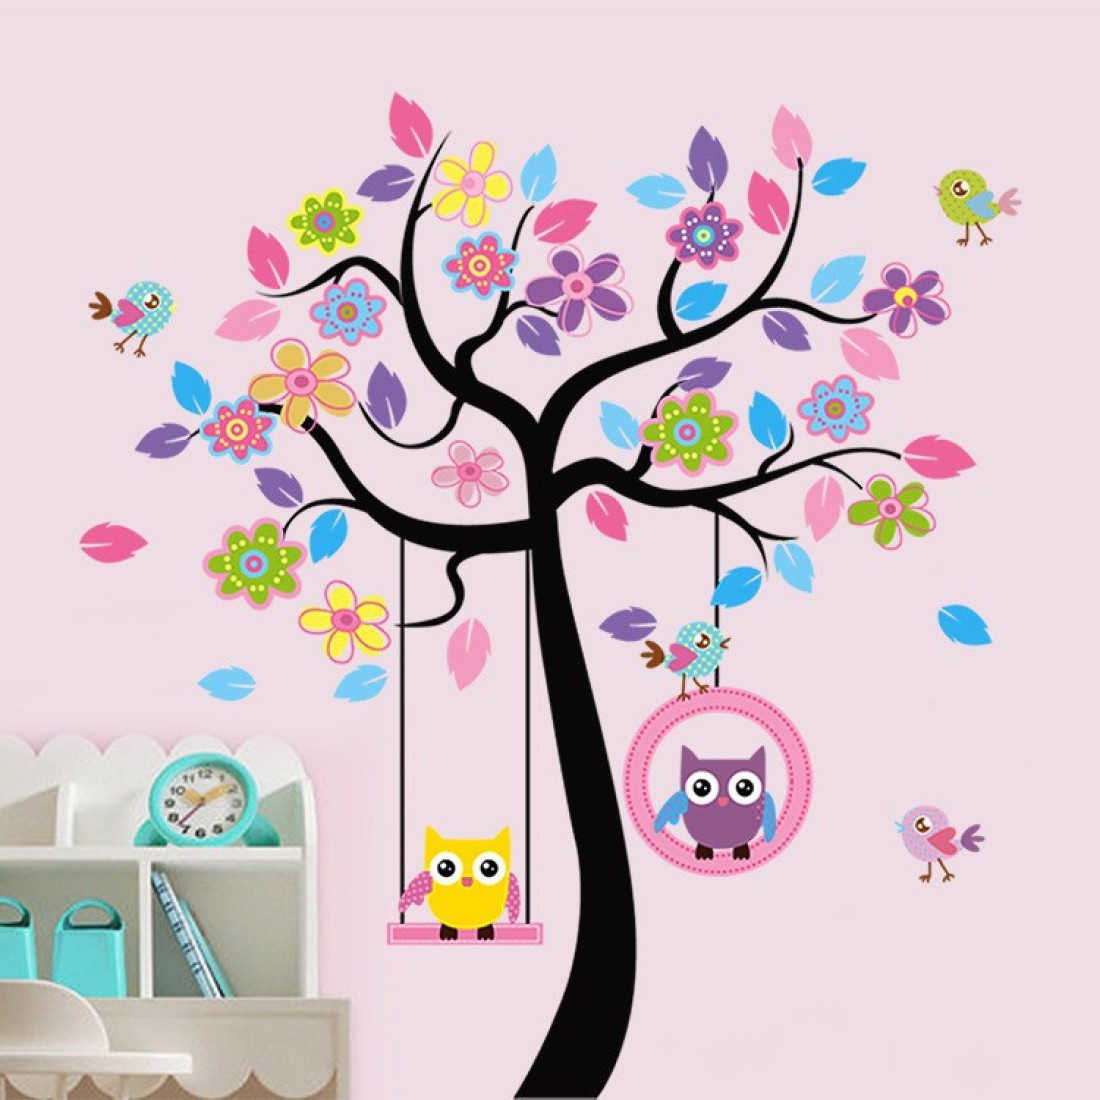

In [12]:
# Définition d'une image comme exemple
test = df_img['img'].iloc[1049]
test_img = Image(test, width=400)
test_img

#### Redimensionnement

In [13]:
# Dimensions de base de l'image choisie
img1 = np.array(Image_PIL.open(test))
img1.shape

(1100, 1100, 3)

In [14]:
# Appel de la fonction pour redimensionner l'image (224 x 224)
im_redim = redim(test, 224, 224)
im_redim

array([[[238, 221, 229],
        [238, 221, 229],
        [238, 221, 229],
        ...,
        [238, 221, 229],
        [238, 221, 229],
        [238, 221, 229]],

       [[238, 221, 229],
        [238, 221, 229],
        [238, 221, 229],
        ...,
        [238, 221, 229],
        [238, 221, 229],
        [238, 221, 229]],

       [[238, 221, 229],
        [238, 221, 229],
        [238, 221, 229],
        ...,
        [238, 221, 229],
        [238, 221, 229],
        [238, 221, 229]],

       ...,

       [[188, 174, 155],
        [140, 113,  96],
        [134, 110,  88],
        ...,
        [238, 221, 229],
        [238, 221, 229],
        [238, 221, 229]],

       [[182, 168, 149],
        [144, 117,  98],
        [143, 116,  92],
        ...,
        [238, 221, 229],
        [238, 221, 229],
        [238, 221, 229]],

       [[187, 171, 151],
        [140, 116,  96],
        [138, 111,  89],
        ...,
        [238, 221, 229],
        [238, 221, 229],
        [238, 221, 229]]

#### Réduction de bruit (flou gaussien)

La réduction de bruit consiste en l'uniformisation  des parties d'une image en les floutant, et en harmonisant ses détails.

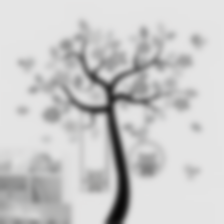

In [15]:
# Application sur notre image d'exemple
im_gauss = gaussian_filter(im_redim, sigma=3)

im_gauss = Image_PIL.fromarray(im_gauss)
im_gauss

#### Egalisation

L'égalisation est l'augmentation du contraste et la répartition uniforme entre le point le plus clair et le point le plus foncé.

<Figure size 600x400 with 0 Axes>

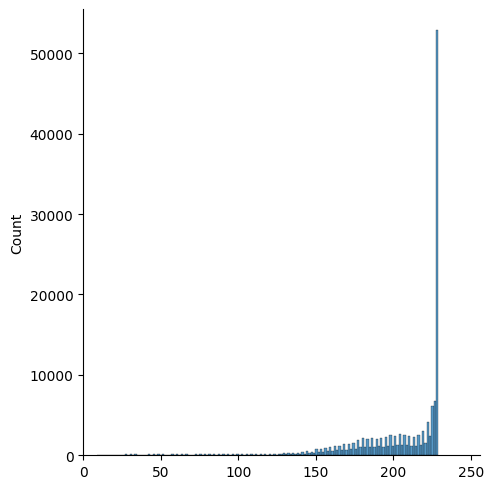

In [16]:
# Aperçu de la répartition initiale de notre image d'exemple
im_egal = np.array(im_gauss)
hist, bins = np.histogram(im_egal.flatten(), 256, [0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.figure(figsize=(6,4))
sns.displot(im_egal.flatten())
plt.xlim([0,256])
plt.show()

<Figure size 600x400 with 0 Axes>

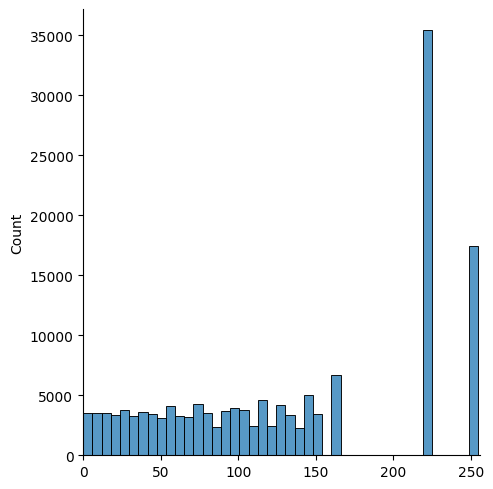

In [17]:
# Aperçu après égalisation
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

im_egal=cdf[im_egal]

plt.figure(figsize=(6,4))
sns.displot(im_egal.flatten())
plt.xlim([0,256])
plt.show()

#### Extraction des descripteurs (SIFT)

Les descripteurs permettent d'identifier les caractéristiques visuelles d'une image dans un ensemble de sous régions.  
  
Nous utiliserons les approches SIFT et ORB.

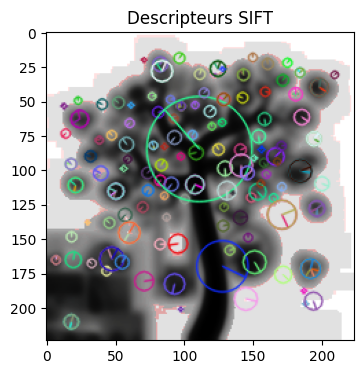

In [18]:
# Application de la méthode SIFT à notre image d'exemple
im_sift = im_egal

sift = cv2.SIFT_create()
kp = sift.detect(im_sift,None)
img=cv2.drawKeypoints(im_sift,kp,im_sift,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(4,4))
plt.title('Descripteurs SIFT')
plt.imshow(img)

#### Extraction des descripteurs (ORB)

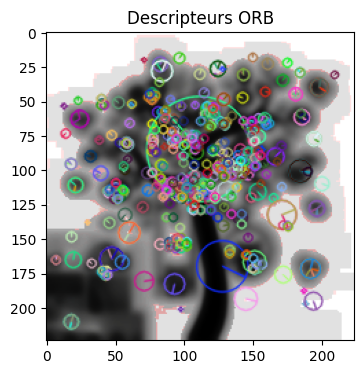

In [19]:
# Application de la méthode ORB à notre image d'exemple
im_orb = im_egal

orb = cv2.ORB_create()
kp, des = orb.detectAndCompute(im_orb, mask = None)
image_orb = cv2.drawKeypoints(im_orb, kp, outImage = True, flags=2)

plt.figure(figsize=(4,4))
plt.title('Descripteurs ORB')
plt.imshow(image_orb)
plt.show()

# Traitement des catégories

#### Liste des catégories réelles

In [20]:
# Liste des catégories réelles
df_img['main_cat'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [21]:
# Définition des labels correspondants aux catégories réelles
cat_labels = ['Home Furnishing', 
              'Baby Care', 
              'Watches',
              'Home Decor & Festive Needs', 
              'Kitchen & Dining',
              'Beauty and Personal Care', 
              'Computers'
             ]

#### 3 exemples d'images pour chaque catégorie

Home Furnishing


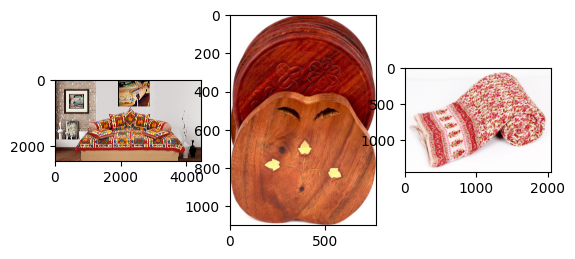

Baby Care


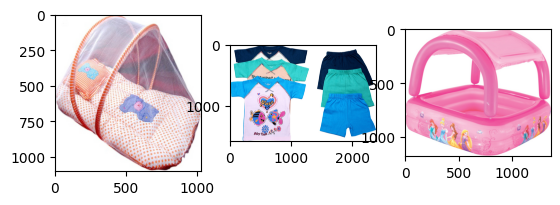

Watches


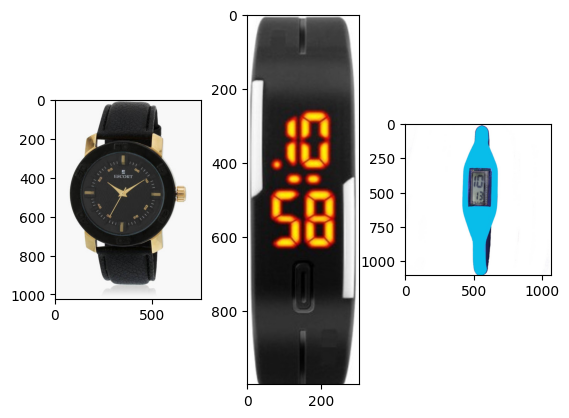

Home Decor & Festive Needs


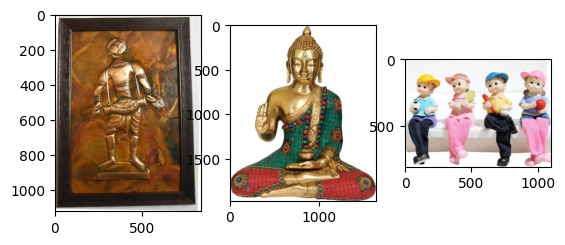

Kitchen & Dining


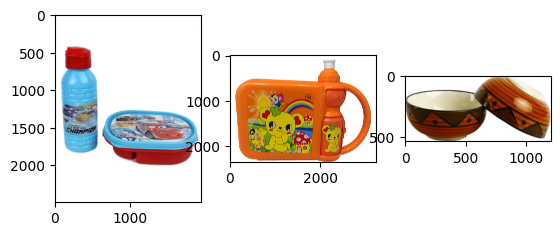

Beauty and Personal Care


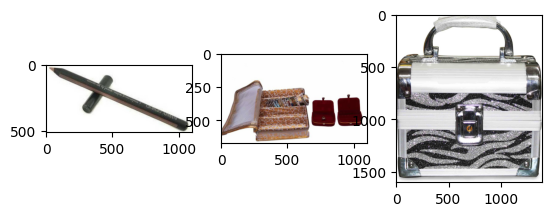

Computers


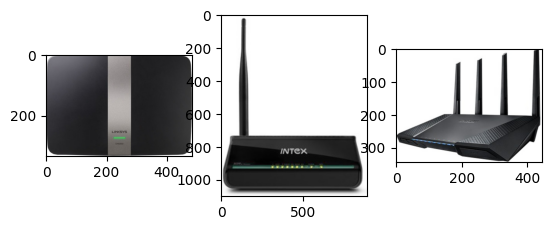

In [22]:
list_Home_Furnishing = [df_img['image'][i] for i in range(len(df_img)) if df_img['main_cat'][i] == 'Home Furnishing']
list_Baby_Care = [df_img['image'][i] for i in range(len(df_img)) if df_img['main_cat'][i] == 'Baby Care']
list_Watches = [df_img['image'][i] for i in range(len(df_img)) if df_img['main_cat'][i] == 'Watches']
list_Home_Decor = [df_img['image'][i] for i in range(len(df_img)) if df_img['main_cat'][i] == 'Home Decor & Festive Needs']
list_Kitchen = [df_img['image'][i] for i in range(len(df_img)) if df_img['main_cat'][i] == 'Kitchen & Dining']
list_Beauty = [df_img['image'][i] for i in range(len(df_img)) if df_img['main_cat'][i] == 'Beauty and Personal Care']
list_Computers = [df_img['image'][i] for i in range(len(df_img)) if df_img['main_cat'][i] == 'Computers']

for name in cat_labels :
    print(name)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# Paramétrage global préalable aux essais de segmentation

In [23]:
# Liste des différentes catégories réelles
l_cat = list(set(df_img['main_cat']))

# Dimensions souhaitées pour les images (ne s'applique pas à tous les modèles)
dim = (224, 224)

# Génération d'une liste de stockage des résultats de modélisation
Results = np.empty(shape=[0, 3])

# Etude de faisabilité

Nous utiliserons les méthodes suivantes :  
  
Essai 1 : features SIFT  
Essai 2 : Resnet50  
Essai 3 : VGG16  
Essai 4 : VGG19  
Essai 5 : Xception  
Essai 6 : InceptionV3  
  
Pour chaque méthode, nous testerons une réduction de dimension via PCA et T-SNE.  
Nous évaluerons la pertinence des résultats via le score ARI et le temps de traitement.  
Enfin, nosu représenterons une matrice de confusion des prédictions via le T-SNE.

### Essai de segmentation 1 : features SIFT

#### Création des descripteurs SIFT pour toutes les images

In [24]:
# Copie du fichier
df_sift = df_img.copy()

# Paramétrage du SIFT
sift = cv2.xfeatures2d.SIFT_create()
size = 35

In [25]:
df_sift['SIFT_features'] = df_sift['img'].apply(features_sift)
df_sift.dropna(axis=0, inplace = True)
df_sift.head()

image         main_cat   
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing  \
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                             img  cat   
0  ./Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg    4  \
1  ./Images/7b72c92c2f6c40268628ec5f14c6d590.jpg    0   
2  ./Images/64d5d4a258243731dc7bbb1eef49ad74.jpg    0   
3  ./Images/d4684dcdc759dd9cdf41504698d737d8.jpg    4   
4  ./Images/6325b6870c54cd47be6ebfbffa620ec7.jpg    4   

                                       SIFT_features  
0  [[0.0, 0.0, 41.0, 61.0, 4.0, 1.0, 1.0, 0.0, 0....  
1  [[1.0, 1.0, 0.0, 7.0, 49.0, 26.0, 9.0, 0.0, 14...  
2  [[2.0, 1.0, 0.0, 1.0, 23.0, 28.0, 15.0, 7.0, 7...  
3  [[60.0, 6.0, 9.0, 23.0, 22.0, 28.0, 35.0, 108....  
4  [[4.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0,...

#### Comparaison des descripteurs sur des images de même catégorie

Category :  Home Furnishing
img 1 :  73
img 2 :  640


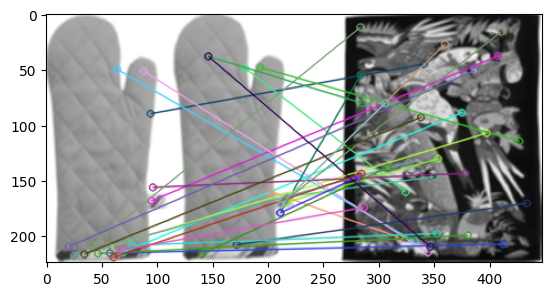

Category :  Computers
img 1 :  77
img 2 :  607


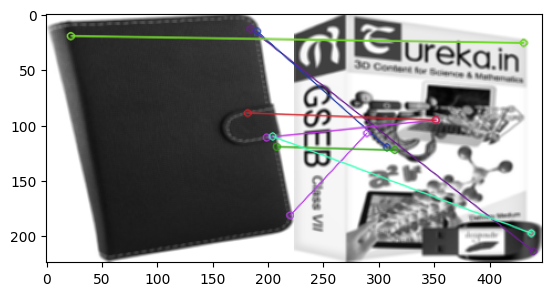

Category :  Watches
img 1 :  250
img 2 :  390


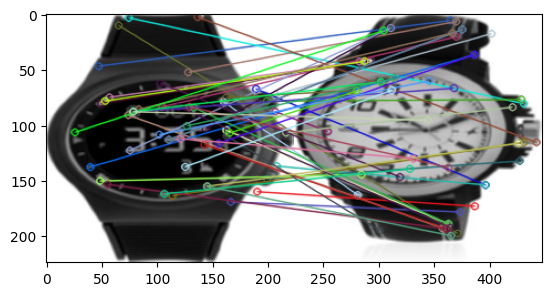

Category :  Home Decor & Festive Needs
img 1 :  311
img 2 :  153


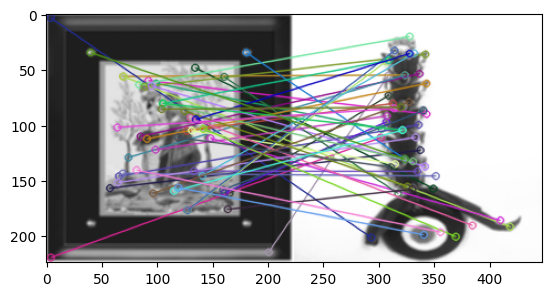

Category :  Baby Care
img 1 :  432
img 2 :  126


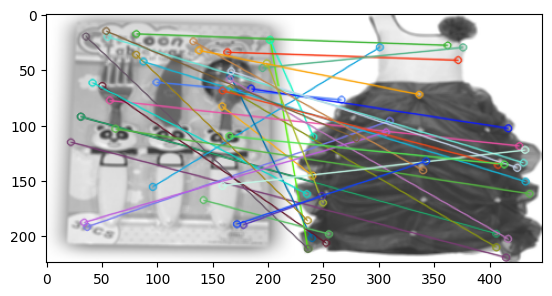

Category :  Beauty and Personal Care
img 1 :  193
img 2 :  438


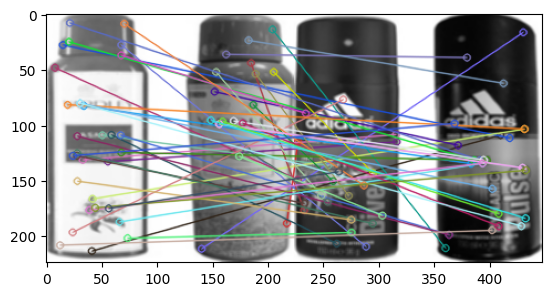

Category :  Kitchen & Dining
img 1 :  73
img 2 :  125


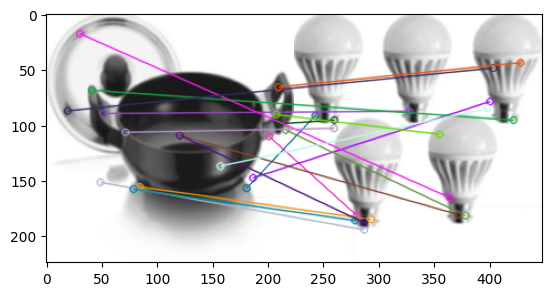

In [26]:
for cat in l_cat:
    print("Category : ", cat)

    data_sample = df_sift[df_sift['main_cat'] == cat].sample(2)

    image_name_1 = data_sample.img.values[0]
    image_name_2 = data_sample.img.values[1]

    img1 = cv2.imread(image_name_1)
    img2 = cv2.imread(image_name_2)

    img1 = cv2.resize(img1, dim, interpolation=cv2.INTER_AREA)
    img2 = cv2.resize(img2, dim, interpolation=cv2.INTER_AREA)

    img1 = cv2.GaussianBlur(img1, (3, 3), cv2.BORDER_DEFAULT)
    img2 = cv2.GaussianBlur(img2, (3, 3), cv2.BORDER_DEFAULT)

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)

    print("img 1 : ", len(keypoints_1))
    print("img 2 : ", len(keypoints_2))

    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

    matches = bf.match(descriptors_1, descriptors_2)
    matches = sorted(matches, key=lambda x: x.distance)

    img3 = cv2.drawMatches(
        img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2
    )
    plt.imshow(img3), plt.show()

#### Clustering

In [27]:
df_sift = df_sift[['main_cat', 'SIFT_features']]

sift_features = np.asarray(df_sift["SIFT_features"])
sift_features = np.stack(sift_features, axis=0)
print(sift_features.shape)

(1011, 35, 128)


In [28]:
nsamples, nx, ny = sift_features.shape
sift = sift_features.reshape((nsamples, nx * ny))

#### Réduction de dimension via PCA et clustering via KMeans (n_clusters = 7)

In [29]:
y_cat_num = [
    (1 - l_cat.index(df_sift.iloc[i]['main_cat']))
    for i in range(len(df_sift))
]

ARI = PCA_eval(sift)

Results = np.append(Results, [['SIFT', 'PCA', ARI]], axis = 0)

Dimension initiale :  (1011, 4480)
Dimension finale : (1011, 720)
ARI :  0.0174 / Time :  4.0


#### Réduction de dimension via T-SNE et clustering via KMeans (n_clusters = 7)

In [30]:
ARI, X_tsne, labels = ARI_fct(sift)

ARI :  0.0166 / Time :  4.0


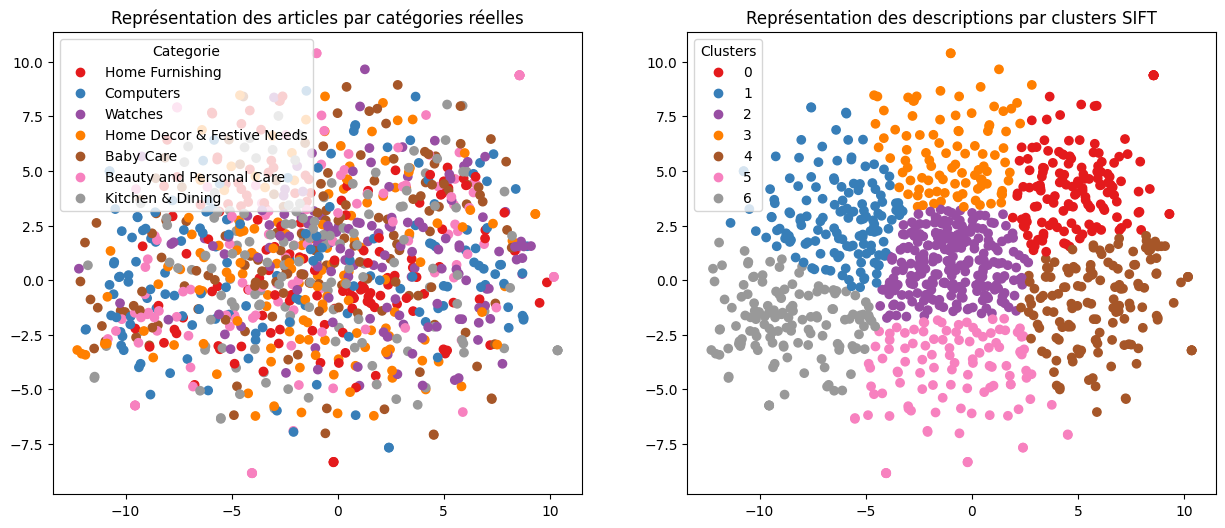

In [31]:
method = 'SIFT'
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Results = np.append(Results, [['SIFT', 'T-SNE', ARI]], axis = 0)

#### Evaluation de la segmentation via T-SNE

Correspondance des clusters :  [0 0 6 1 6 1 3]
Accuracy : 0.1632

Score ARI : 0.0166

[[85 16  0 11  0  0 32]
 [45 67  0 12  0  0 25]
 [35 42  0 11  0  0 38]
 [44 42  0 30  0  0 33]
 [62 35  0 20  0  0 31]
 [61 36  0 17  0  0 31]
 [54 37  0 10  0  0 49]]

              precision    recall  f1-score   support

           0       0.22      0.59      0.32       144
           1       0.24      0.45      0.32       149
           2       0.00      0.00      0.00       126
           3       0.27      0.20      0.23       149
           4       0.00      0.00      0.00       148
           5       0.00      0.00      0.00       145
           6       0.21      0.33      0.25       150

    accuracy                           0.23      1011
   macro avg       0.13      0.22      0.16      1011
weighted avg       0.14      0.23      0.16      1011



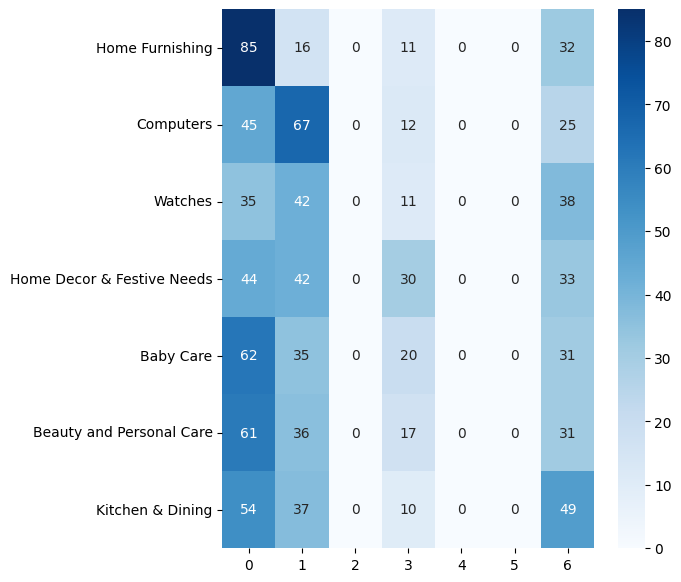

In [32]:
# Clustering KMeans (7 clusters)
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

# Création Dataframe réduite via T-SNE et segmentée via KMeans
df_tsne = pd.DataFrame(X_tsne, columns = ['tsne1', 'tsne2'])
df_tsne['class'] = df_sift['main_cat'].values
df_tsne['cluster'] = cls.labels_

# Encodage de la catégorie réelle
encoder = preprocessing.LabelEncoder()
df_tsne['cat'] = encoder.fit_transform(df_tsne['class'])

# Evaluation du modèle : score ARI et matrice de confusion
CM_matrix(df_tsne, 'cat')

Il apparaît ici clairement que la méthode des descripteurs SIFT n'est pas efficace. Score ARI très faible matrice de confusion montrant l'inefficacité des prédictions.

In [33]:
# Liste numérique des catégories réelles pour les modèles suivants
y_cat_num = [
    (1 - l_cat.index(df_img.iloc[i]['main_cat']))
    for i in range(len(df_img))
]

### Essai de segmentation 2 : ResNet50

#### Paramétrage du modèle

In [34]:
ResNet_model = ResNet50(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='avg'
)
ResNet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

#### Préparation des images

In [35]:
X = []
for image_num in range(len(list_photos)):
    img = load_img(df_img['img'][image_num], target_size = dim)
    img = ImageOps.equalize(img, mask = None)
    img = np.array(img)
    reshaped_img = img.reshape(224, 224, 3)
    imgx = resnet.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

#### Création des features

In [36]:
features = ResNet_model.predict(X, use_multiprocessing=True)

33/33 [==============================] - 32s 966ms/step


#### Réduction de dimension via ACP et clustering via KMeans (n_clusters = 7)

In [37]:
ARI = PCA_eval(features)

Dimension initiale :  (1050, 2048)
Dimension finale : (1050, 426)
ARI :  0.4084 / Time :  4.0


In [38]:
Results = np.append(Results, [['ResNet50', 'PCA', ARI]], axis = 0)

#### Réduction de dimension via T-SNE et clustering via KMeans (n_clusters = 7)

In [39]:
ARI, X_tsne, labels = ARI_fct(features)

ARI :  0.5082 / Time :  5.0


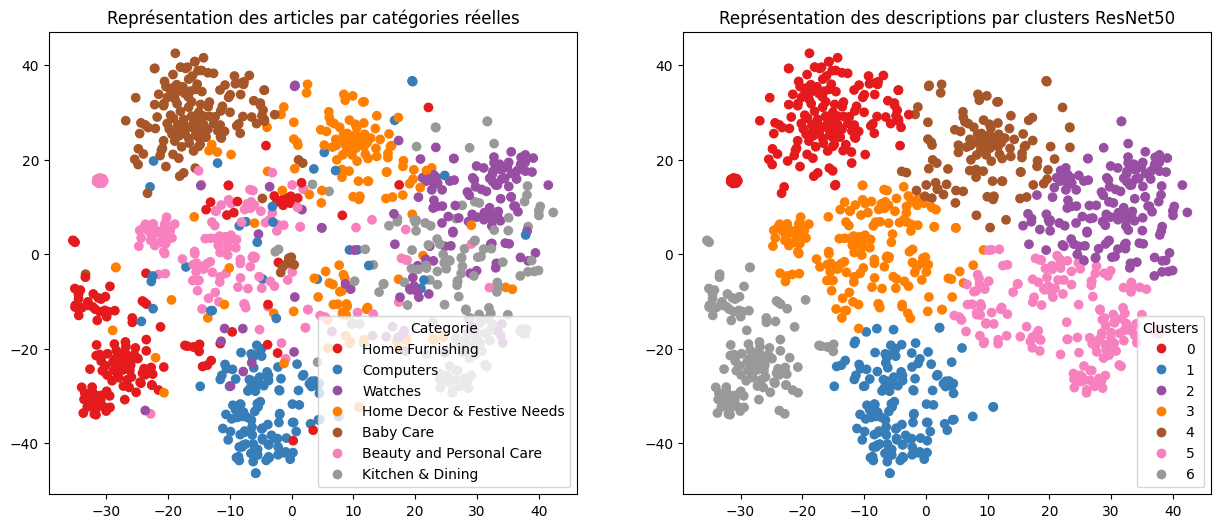

In [40]:
method = "ResNet50"
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Results = np.append(Results, [['ResNet50', 'T-SNE', ARI]], axis = 0)

#### Evaluation de la segmentation via T-SNE

Correspondance des clusters :  [2 6 0 5 3 4 1]
Accuracy : 0.0219

Score ARI : 0.5082

[[ 98   6   7   5  32   1   1]
 [  2 117  14   7   5   2   3]
 [  2   5 117   7   9   1   9]
 [  6   4  12  87  30   6   5]
 [ 50   1   2   5  92   0   0]
 [  0   9  16   6   0 118   1]
 [  0   0   7   2   0   1 140]]

              precision    recall  f1-score   support

           0       0.62      0.65      0.64       150
           1       0.82      0.78      0.80       150
           2       0.67      0.78      0.72       150
           3       0.73      0.58      0.65       150
           4       0.55      0.61      0.58       150
           5       0.91      0.79      0.85       150
           6       0.88      0.93      0.91       150

    accuracy                           0.73      1050
   macro avg       0.74      0.73      0.73      1050
weighted avg       0.74      0.73      0.73      1050



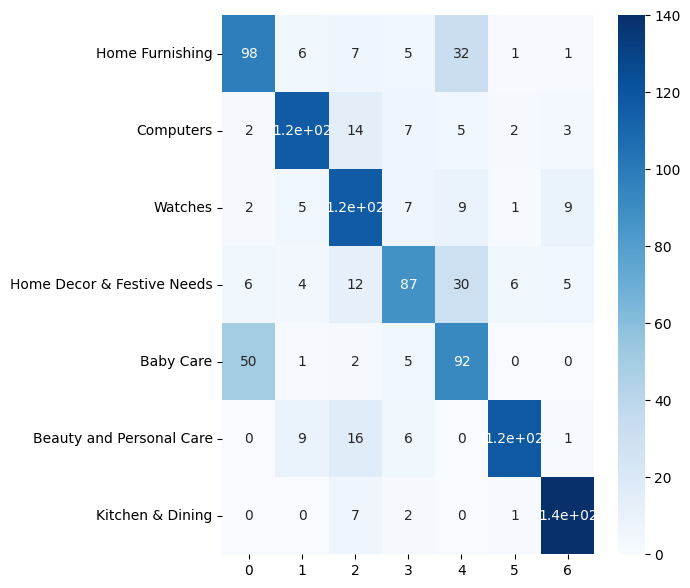

In [42]:
# Clustering KMeans (7 clusters)
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

# Création Dataframe réduite via T-SNE et segmentée via KMeans
df_tsne = pd.DataFrame(X_tsne, columns = ['tsne1', 'tsne2'])
df_tsne['class'] = df_img['main_cat'].values
df_tsne['cluster'] = cls.labels_

# Encodage de la catégorie réelle
encoder = preprocessing.LabelEncoder()
df_tsne['cat'] = encoder.fit_transform(df_tsne['class'])

# Evaluation du modèle : score ARI et matrice de confusion
CM_matrix(df_tsne, 'cat')

### Essai de segmentation 3 : VGG16

#### Paramétrage du modèle

In [43]:
VGG16_model = VGG16(include_top = True, weights = "imagenet")

VGG16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Préparation des images

In [44]:
X = []
for image_num in range(len(list_photos)):
    img = load_img(df_img['img'][image_num], target_size = dim)
    img = ImageOps.equalize(img, mask = None)
    img = np.array(img)
    reshaped_img = img.reshape(224, 224, 3)
    imgx = vgg16.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

#### Création des features

In [45]:
VGG16_model = VGG16()

VGG16_model = Model(inputs=VGG16_model.inputs,
                    outputs=VGG16_model.layers[-2].output)

features = VGG16_model.predict(X, use_multiprocessing = True)

33/33 [==============================] - 62s 2s/step


#### Réduction de dimension via PCA et clustering via KMeans (n_clusters = 7)

In [46]:
ARI = PCA_eval(features)

Dimension initiale :  (1050, 4096)
Dimension finale : (1050, 521)
ARI :  0.3792 / Time :  5.0


In [47]:
Results = np.append(Results, [['VGG16', 'PCA', ARI]], axis = 0)

#### Réduction de dimension via T-SNE et clustering via KMeans (n_clusters = 7)

In [48]:
ARI, X_tsne, labels = ARI_fct(features)

ARI :  0.4398 / Time :  5.0


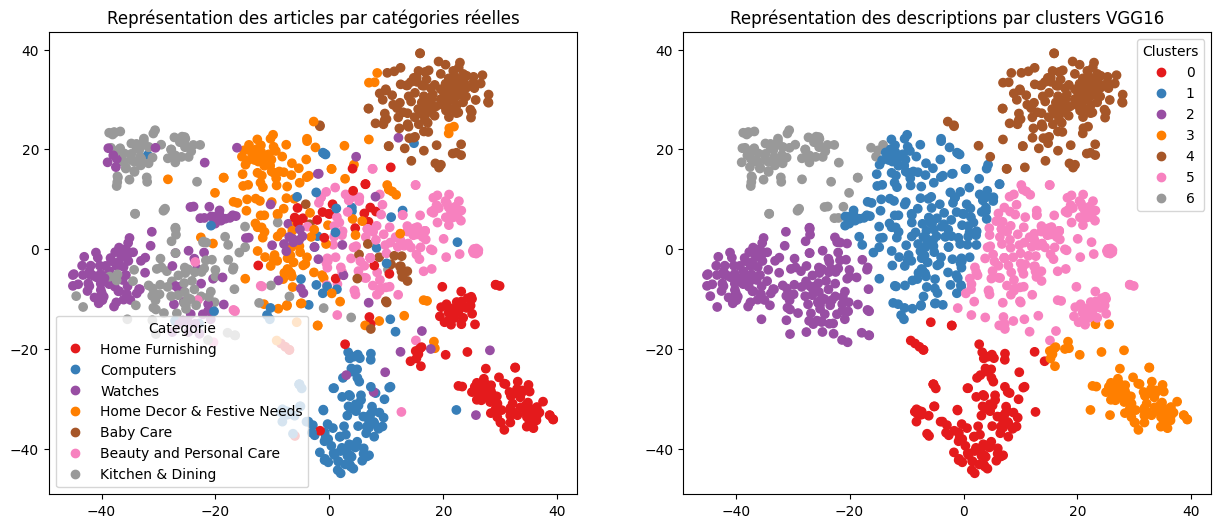

In [49]:
method = "VGG16"
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Results = np.append(Results, [['VGG16', 'T-SNE', ARI]], axis = 0)

#### Evaluation de la segmentation via T-SNE

Correspondance des clusters :  [6 3 5 4 1 0 2]
Accuracy : 0.0429

Score ARI : 0.4398

[[ 93   4   4  31  13   3   2]
 [  3 116   8  20   1   1   1]
 [  6   1 110  31   0   0   2]
 [  2   4  14 112   7   2   9]
 [ 71   0   3   9  67   0   0]
 [  0   8  37  15   0  89   1]
 [  0   0  16   2   0   0 132]]

              precision    recall  f1-score   support

           0       0.53      0.62      0.57       150
           1       0.87      0.77      0.82       150
           2       0.57      0.73      0.64       150
           3       0.51      0.75      0.61       150
           4       0.76      0.45      0.56       150
           5       0.94      0.59      0.73       150
           6       0.90      0.88      0.89       150

    accuracy                           0.68      1050
   macro avg       0.73      0.68      0.69      1050
weighted avg       0.73      0.68      0.69      1050



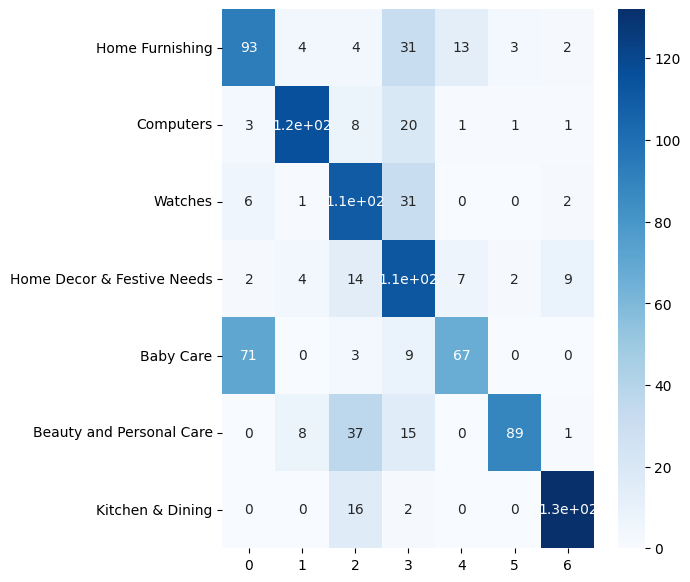

In [50]:
# Clustering KMeans (7 clusters)
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

# Création Dataframe réduite via T-SNE et segmentée via KMeans
df_tsne = pd.DataFrame(X_tsne, columns = ['tsne1', 'tsne2'])
df_tsne['class'] = df_img['main_cat'].values
df_tsne['cluster'] = cls.labels_

# Encodage de la catégorie réelle
encoder = preprocessing.LabelEncoder()
df_tsne['cat'] = encoder.fit_transform(df_tsne['class'])

# Evaluation du modèle : score ARI et matrice de confusion
CM_matrix(df_tsne, 'cat')

### Essai de segmentation 4 : VGG19

#### Paramétrage du modèle

In [51]:
VGG19_model = VGG19(include_top = True, weights = "imagenet")

VGG19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Préparation des images

In [52]:
X = []
for image_num in range(len(list_photos)):
    img = load_img(df_img['img'][image_num], target_size = dim)
    img = ImageOps.equalize(img, mask = None)
    img = np.array(img)
    reshaped_img = img.reshape(224, 224, 3)
    imgx = vgg19.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

#### Création des features

In [53]:
VGG19_model = VGG19()

VGG19_model = Model(inputs = VGG19_model.inputs,
                    outputs = VGG19_model.layers[-2].output)

features = VGG19_model.predict(X, use_multiprocessing = True)

33/33 [==============================] - 77s 2s/step


#### Réduction de dimension via PCA et clustering via KMeans (n_clusters = 7)

In [54]:
ARI = PCA_eval(features)

Dimension initiale :  (1050, 4096)
Dimension finale : (1050, 515)
ARI :  0.3789 / Time :  4.0


In [55]:
Results = np.append(Results, [['VGG19', 'PCA', ARI]], axis = 0)

#### Réduction de dimension via T-SNE et clustering via KMeans (n_clusters = 7)

In [56]:
ARI, X_tsne, labels = ARI_fct(features)

ARI :  0.5321 / Time :  5.0


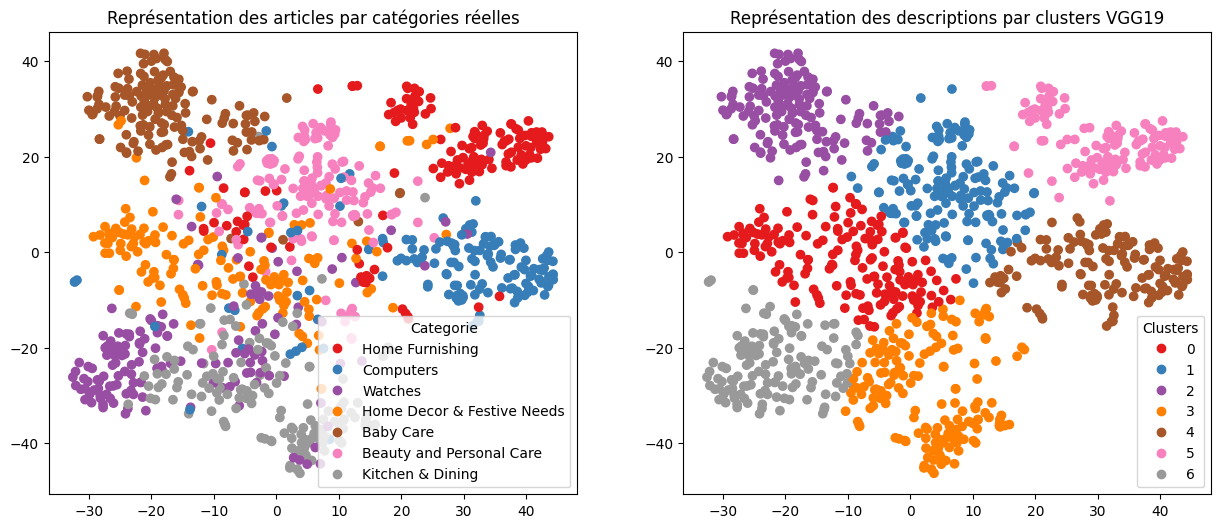

In [57]:
method = "VGG19"
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Results = np.append(Results, [['VGG19', 'T-SNE', ARI]], axis = 0)

#### Evaluation de la segmentation via T-SNE

Correspondance des clusters :  [0 2 6 1 4 3 5]
Accuracy : 0.2105

Score ARI : 0.5301

[[ 87   4   4  19  35   1   0]
 [  5 118  11   7   7   1   1]
 [  2   2 122  12  11   1   0]
 [  5   5  14 108   9   5   4]
 [ 36   0   1   7 105   1   0]
 [  0  14  11  13   0 110   2]
 [  0   0   9   1   0   0 140]]

              precision    recall  f1-score   support

           0       0.64      0.58      0.61       150
           1       0.83      0.79      0.81       150
           2       0.71      0.81      0.76       150
           3       0.65      0.72      0.68       150
           4       0.63      0.70      0.66       150
           5       0.92      0.73      0.82       150
           6       0.95      0.93      0.94       150

    accuracy                           0.75      1050
   macro avg       0.76      0.75      0.75      1050
weighted avg       0.76      0.75      0.75      1050



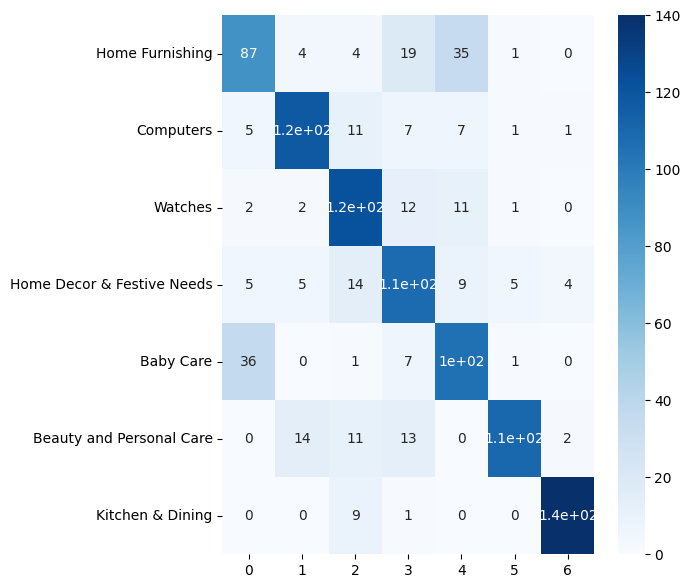

In [58]:
# Clustering KMeans (7 clusters)
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

# Création Dataframe réduite via T-SNE et segmentée via KMeans
df_tsne = pd.DataFrame(X_tsne, columns = ['tsne1', 'tsne2'])
df_tsne['class'] = df_img['main_cat'].values
df_tsne['cluster'] = cls.labels_

# Encodage de la catégorie réelle
encoder = preprocessing.LabelEncoder()
df_tsne['cat'] = encoder.fit_transform(df_tsne['class'])

# Evaluation du modèle : score ARI et matrice de confusion
CM_matrix(df_tsne, 'cat')

### Essai de segmentation 5 : Xception

#### Préparation du modèle

In [59]:
xception_model = Xception(
    include_top = False,
    weights = "imagenet",
    input_shape = (299, 299, 3),
    pooling='avg'
)

xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

#### Préparation des images

In [60]:
X = []

for image_num in range(len(list_photos)):
    img = load_img(df_img['img'][image_num], target_size = (299, 299))
    img = ImageOps.equalize(img, mask = None)
    img = np.array(img)
    reshaped_img = img.reshape(299, 299, 3)
    imgx = xception.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

#### Création des features

In [61]:
features = xception_model.predict(X, use_multiprocessing=True)

33/33 [==============================] - 54s 2s/step


#### Réduction de dimension via PCA et clusting via KMeans (n_clusters = 7)

In [62]:
ARI = PCA_eval(features)

Dimension initiale :  (1050, 2048)
Dimension finale : (1050, 474)
ARI :  0.4713 / Time :  3.0


In [63]:
Results = np.append(Results, [['Xception', 'PCA', ARI]], axis = 0)

#### Réduction de dimension via T-SNE et clustering via KMeans (n_clusters = 7)

In [64]:
ARI, X_tsne, labels = ARI_fct(features)

ARI :  0.5537 / Time :  5.0


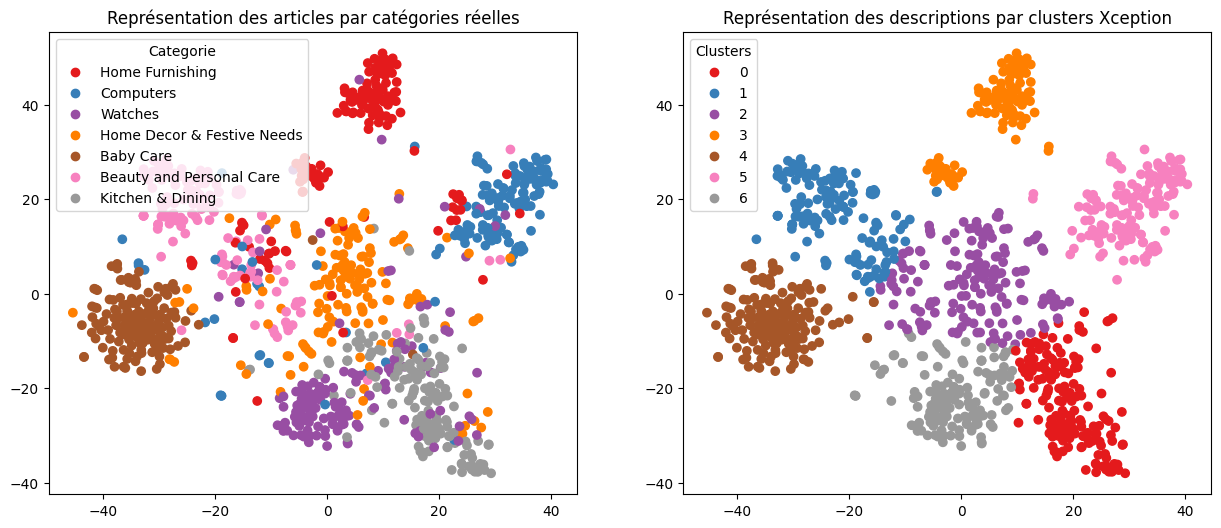

In [65]:
method = "Xception"
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Results = np.append(Results, [['Xception', 'T-SNE', ARI]], axis = 0)

#### Evaluation de la segmentation via T-SNE

Correspondance des clusters :  [2 0 1 6 5 4 3]
Accuracy : 0.0229

Score ARI : 0.5537

[[ 93   6   3   7  35   3   3]
 [  9 121   6   5   3   1   5]
 [  3   3 118  24   1   0   1]
 [ 18   4   3 105  12   0   8]
 [ 21   0   0  12 117   0   0]
 [  1  15  15  13   0 104   2]
 [  0   0   0   1   1   0 148]]

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       150
           1       0.81      0.81      0.81       150
           2       0.81      0.79      0.80       150
           3       0.63      0.70      0.66       150
           4       0.69      0.78      0.73       150
           5       0.96      0.69      0.81       150
           6       0.89      0.99      0.93       150

    accuracy                           0.77      1050
   macro avg       0.78      0.77      0.77      1050
weighted avg       0.78      0.77      0.77      1050



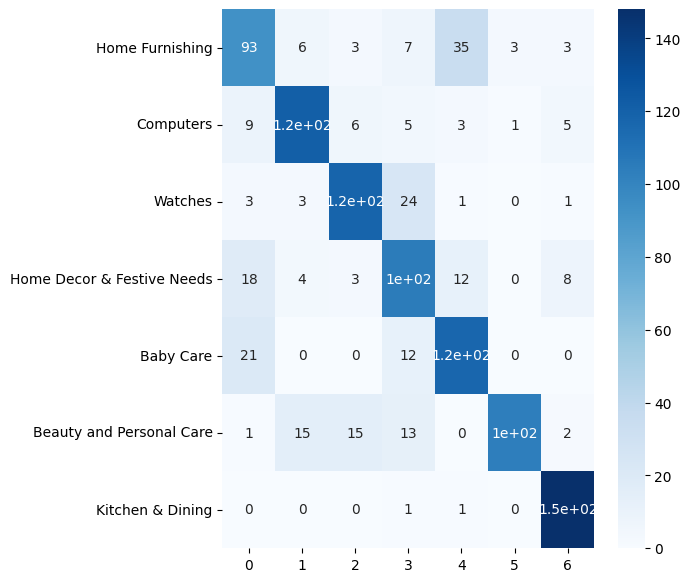

In [66]:
# Clustering KMeans (7 clusters)
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

# Création Dataframe réduite via T-SNE et segmentée via KMeans
df_tsne = pd.DataFrame(X_tsne, columns = ['tsne1', 'tsne2'])
df_tsne['class'] = df_img['main_cat'].values
df_tsne['cluster'] = cls.labels_

# Encodage de la catégorie réelle
encoder = preprocessing.LabelEncoder()
df_tsne['cat'] = encoder.fit_transform(df_tsne['class'])

# Evaluation du modèle : score ARI et matrice de confusion
CM_matrix(df_tsne, 'cat')

### Essai de segmentation 6 : InceptionV3

#### Préparation du modèle

In [67]:
model_incep = InceptionV3(
    weights = "imagenet",
    input_shape = (299, 299, 3),
    include_top = False,
    pooling = 'avg'
)

model_incep.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 149, 149, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 149, 149, 32  96         ['conv2d_4[0][0]']               
 rmalization)                   )                                                      

 batch_normalization_9 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 64)  192         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_14 (BatchN  (None, 35, 35, 96)  288         ['conv2d_14[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_15 (BatchN  (None, 35, 35, 32)  96          ['conv2d_15[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_26 (BatchN  (None, 35, 35, 64)  192         ['conv2d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_27 (Conv2D)             (None, 35, 35, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_38 (Conv2D)             (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_38 (BatchN  (None, 17, 17, 128)  384        ['conv2d_38[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_48 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_48 (BatchN  (None, 17, 17, 160)  480        ['conv2d_48[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_48[0][0]'] 
                                                                                                  
 conv2d_49 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_59 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_59 (BatchN  (None, 17, 17, 160)  480        ['conv2d_59[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_59[0][0]'] 
          

                                                                                                  
 batch_normalization_69 (BatchN  (None, 17, 17, 192)  576        ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_69[0][0]'] 
                                                                                                  
 conv2d_65 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_78 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_74 (BatchN  (None, 17, 17, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_78 (BatchN  (None, 17, 17, 192)  576        ['conv2d_78[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_80 (BatchN  (None, 8, 8, 320)   960         ['conv2d_80[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_86[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_87[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_95[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_96[0][0]'] 
                                                                                                  
 batch_normalization_97 (BatchN  (None, 8, 8, 192)   576         ['conv2d_97[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_89[0][0]'] 
                                                                                                  
 mixed9_1 

#### Préparation des images

In [68]:
X = []

for image_num in range(len(list_photos)):
    img = load_img(df_img['img'][image_num], target_size = (299, 299))
    img = ImageOps.equalize(img, mask = None)
    img = np.array(img)
    reshaped_img = img.reshape(299, 299, 3)
    imgx = inception_v3.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

#### Création des features

In [69]:
features = model_incep.predict(X, use_multiprocessing = True)

33/33 [==============================] - 30s 882ms/step


#### Réduction de dimension via PCA et clustering via KMeans (n_clusters = 7)

In [70]:
ARI = PCA_eval(features)

Dimension initiale :  (1050, 2048)
Dimension finale : (1050, 425)
ARI :  0.4583 / Time :  4.0


In [71]:
Results = np.append(Results, [['InceptionV3', 'PCA', ARI]], axis = 0)

#### Réduction de dimension via T-SNE et clustering via KMeans (n_clusters = 7)

In [72]:
ARI, X_tsne, labels = ARI_fct(features)

ARI :  0.5422 / Time :  4.0


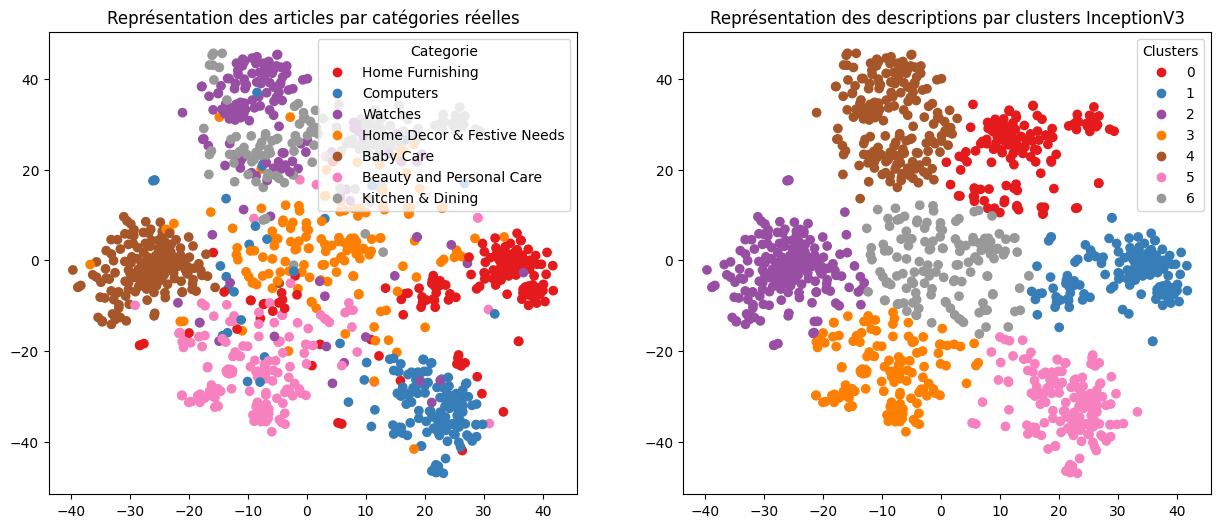

In [73]:
method = "InceptionV3"
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Results = np.append(Results, [['InceptionV3', 'T-SNE', ARI]], axis = 0)

#### Evaluation de la segmentation via T-SNE

Correspondance des clusters :  [4 1 6 2 0 5 3]
Accuracy : 0.3067

Score ARI : 0.5422

[[110   4   7   5  16   5   3]
 [  4 122   7   6   4   1   6]
 [  1   3 118  17   2   3   6]
 [  3   5   2  93  27  13   7]
 [ 64   0   0   6  80   0   0]
 [  0  16   5  12   1 111   5]
 [  0   0   0   1   0   0 149]]

              precision    recall  f1-score   support

           0       0.60      0.73      0.66       150
           1       0.81      0.81      0.81       150
           2       0.85      0.79      0.82       150
           3       0.66      0.62      0.64       150
           4       0.62      0.53      0.57       150
           5       0.83      0.74      0.78       150
           6       0.85      0.99      0.91       150

    accuracy                           0.75      1050
   macro avg       0.75      0.75      0.74      1050
weighted avg       0.75      0.75      0.74      1050



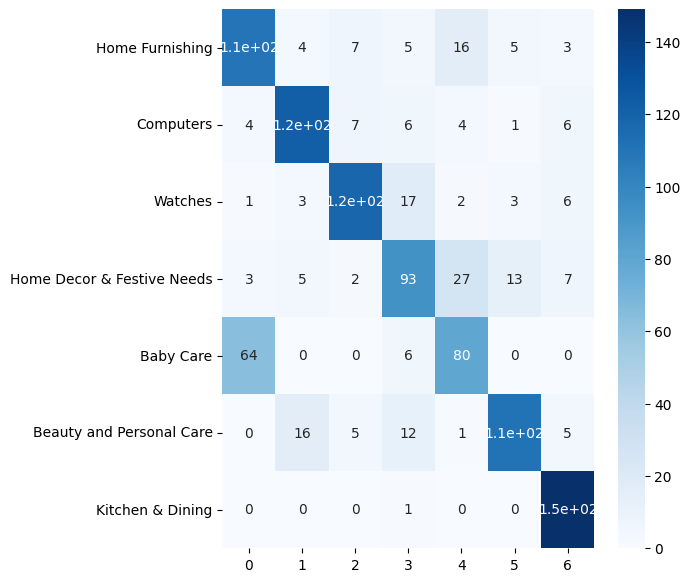

In [74]:
# Clustering KMeans (7 clusters)
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

# Création Dataframe réduite via T-SNE et segmentée via KMeans
df_tsne = pd.DataFrame(X_tsne, columns = ['tsne1', 'tsne2'])
df_tsne['class'] = df_img['main_cat'].values
df_tsne['cluster'] = cls.labels_

# Encodage de la catégorie réelle
encoder = preprocessing.LabelEncoder()
df_tsne['cat'] = encoder.fit_transform(df_tsne['class'])

# Evaluation du modèle : score ARI et matrice de confusion
CM_matrix(df_tsne, 'cat')

# BILAN : Performances des modèles

#### Tableau des scores ARI pour chaque modèle

In [75]:
# Affichage de la dataframe Results, combinant les scores ARI de chaque méthode
df_results = pd.DataFrame(Results, columns = ["Model", "Reduction", "ARI"])
df_results

Model Reduction     ARI
0          SIFT       PCA  0.0174
1          SIFT     T-SNE  0.0166
2      ResNet50       PCA  0.4084
3      ResNet50     T-SNE  0.5082
4         VGG16       PCA  0.3792
5         VGG16     T-SNE  0.4398
6         VGG19       PCA  0.3789
7         VGG19     T-SNE  0.5321
8      Xception       PCA  0.4713
9      Xception     T-SNE  0.5537
10  InceptionV3       PCA  0.4583
11  InceptionV3     T-SNE  0.5422

#### Représentation graphique

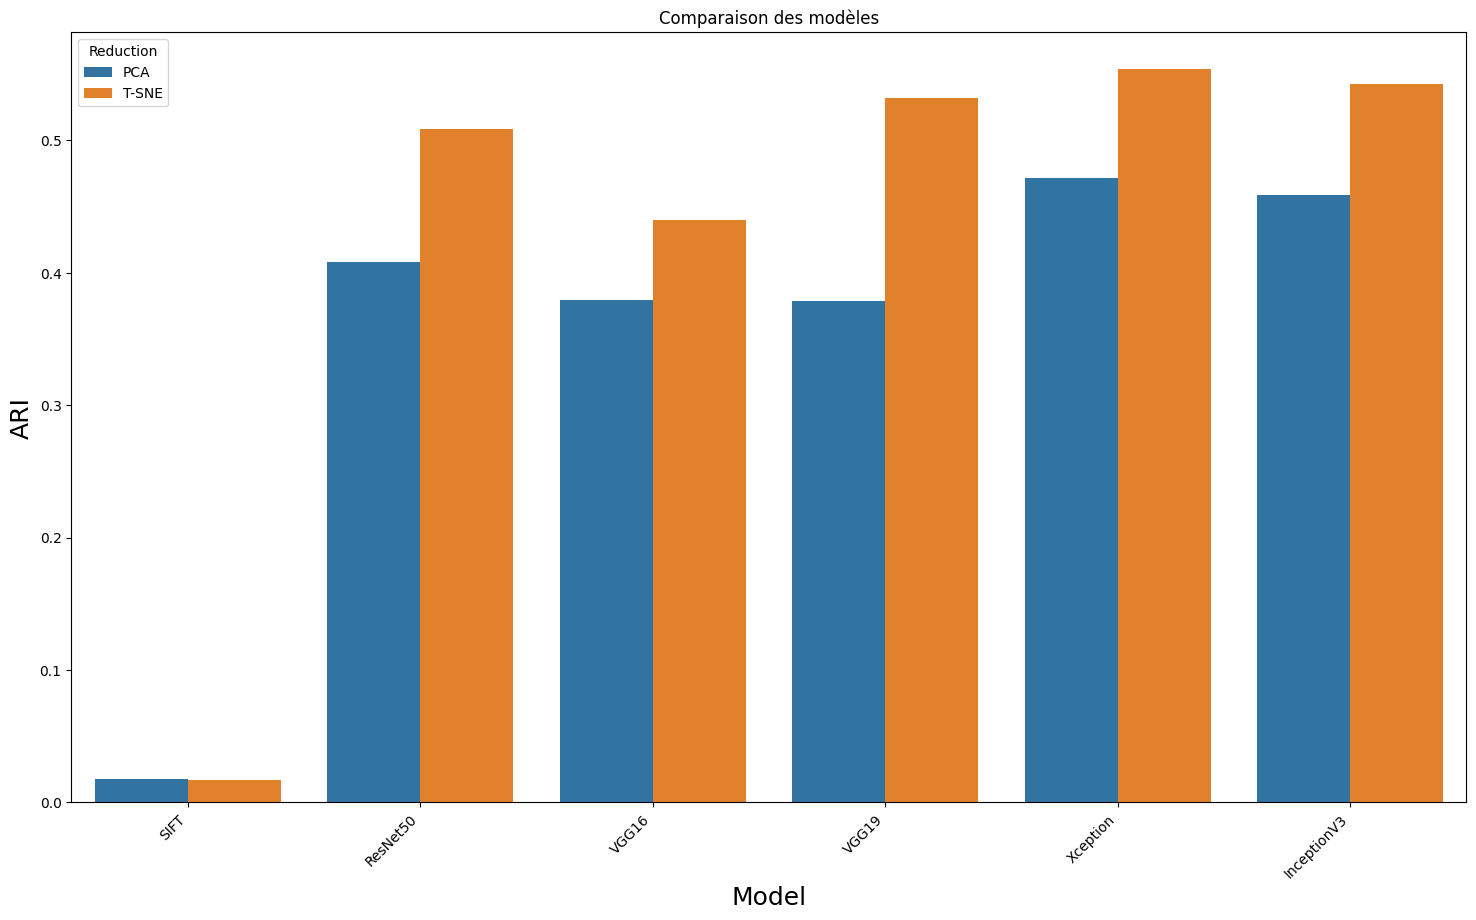

In [77]:
# Représentation graphique des résultats
df_results['ARI'] = df_results['ARI'].astype(float)

plt.figure(figsize=(18, 10))

sns.barplot(data=df_results, x="Model", y="ARI", hue='Reduction')
plt.xticks(rotation=45, ha='right')
plt.title('Comparaison des modèles')
plt.xlabel('Model', fontsize=18)
plt.ylabel('ARI', fontsize=18)

plt.show()

#### Conclusion :  
  
L'approche par les descripteurs SIFT présentent des résultats bien inférieurs aux autres méthodes.  
Le modèle avec la meilleure évaluation est Xception, réduit via le T-SNE (ARI = 0.5537).  
Nous testerons donc ce modèle au sein d'une classification supervisée dans le Notebook 3. 